# EDSR

In [1]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.edsr import edsr
from train import EdsrTrainer

%matplotlib inline

In [2]:
# Number of residual blocks
depth = 16

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/edsr-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [4]:
#div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
#div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [5]:
#train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
#valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-edsr-16-x4.tar.gz](https://martin-krasser.de/sisr/weights-edsr-16-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/edsr-16-x4` directory containing the weights of the pre-trained model.

In [6]:
##trainer = EdsrTrainer(model=edsr(scale=scale, num_res_blocks=depth), 
##                      checkpoint_dir=f'.ckpt/edsr-{depth}-x{scale}')

In [7]:
# Train EDSR model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
##trainer.train(train_ds,
##              valid_ds.take(10),
##              steps=300000, 
##              evaluate_every=1000, 
##              save_best_only=True)

In [8]:
# Restore from checkpoint with highest PSNR
##trainer.restore()

In [9]:
# Evaluate model on full validation set
##psnrv = trainer.evaluate(valid_ds)
##print(f'PSNR = {psnrv.numpy():3f}')

In [10]:
# Save weights to separate location (needed for demo)
##trainer.model.save_weights(weights_file)

## Demo

In [11]:
model = edsr(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [12]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

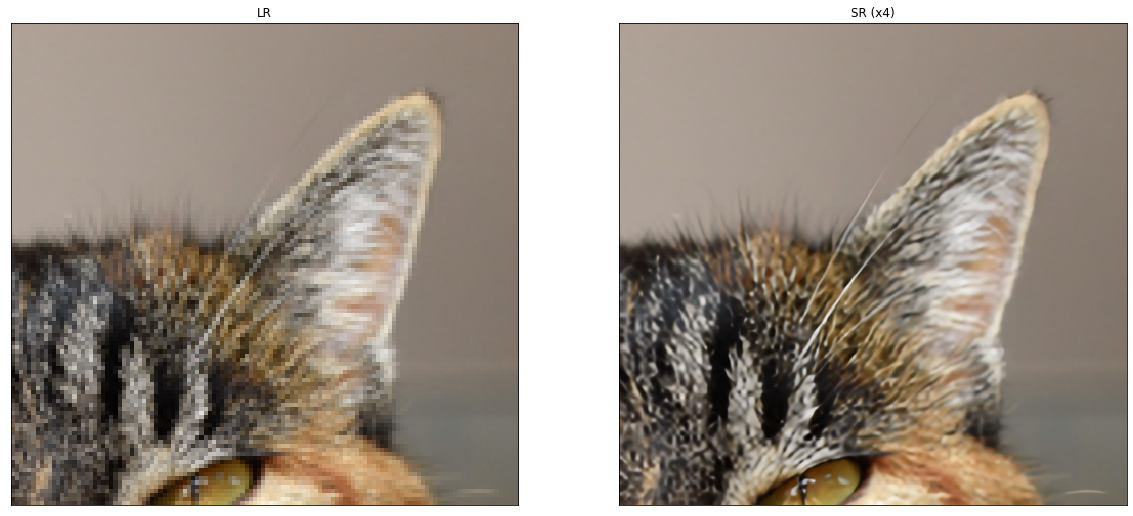

In [13]:
resolve_and_plot('demo/0869x4-crop.png')

## Following codes are experiment with ETOPO1 data

### Exp color encoding with matplotlib

In [14]:
from osgeo import gdal

In [15]:
fp = '/att/nobackup/jli30/data/water_map/ETOPO1_Ice_c.tif'
ds = gdal.Open(fp)
arr = ds.GetRasterBand(1).ReadAsArray()
arr.shape

(10800, 21600)

In [16]:
arr.min(), arr.max()

(-10803, 8333)

#### crop out a smaller region for testing 

In [17]:
xss, xes, yss, yes = 6570, 6750, 2370, 2670
top_s = arr[yss:yes, xss:xes]

In [18]:
top_s.shape

(300, 180)

In [42]:
top_s[:5, :5]

array([[536, 540, 508, 485, 487],
       [526, 544, 510, 482, 484],
       [541, 522, 497, 473, 477],
       [544, 504, 486, 475, 513],
       [527, 502, 482, 486, 543]], dtype=int16)

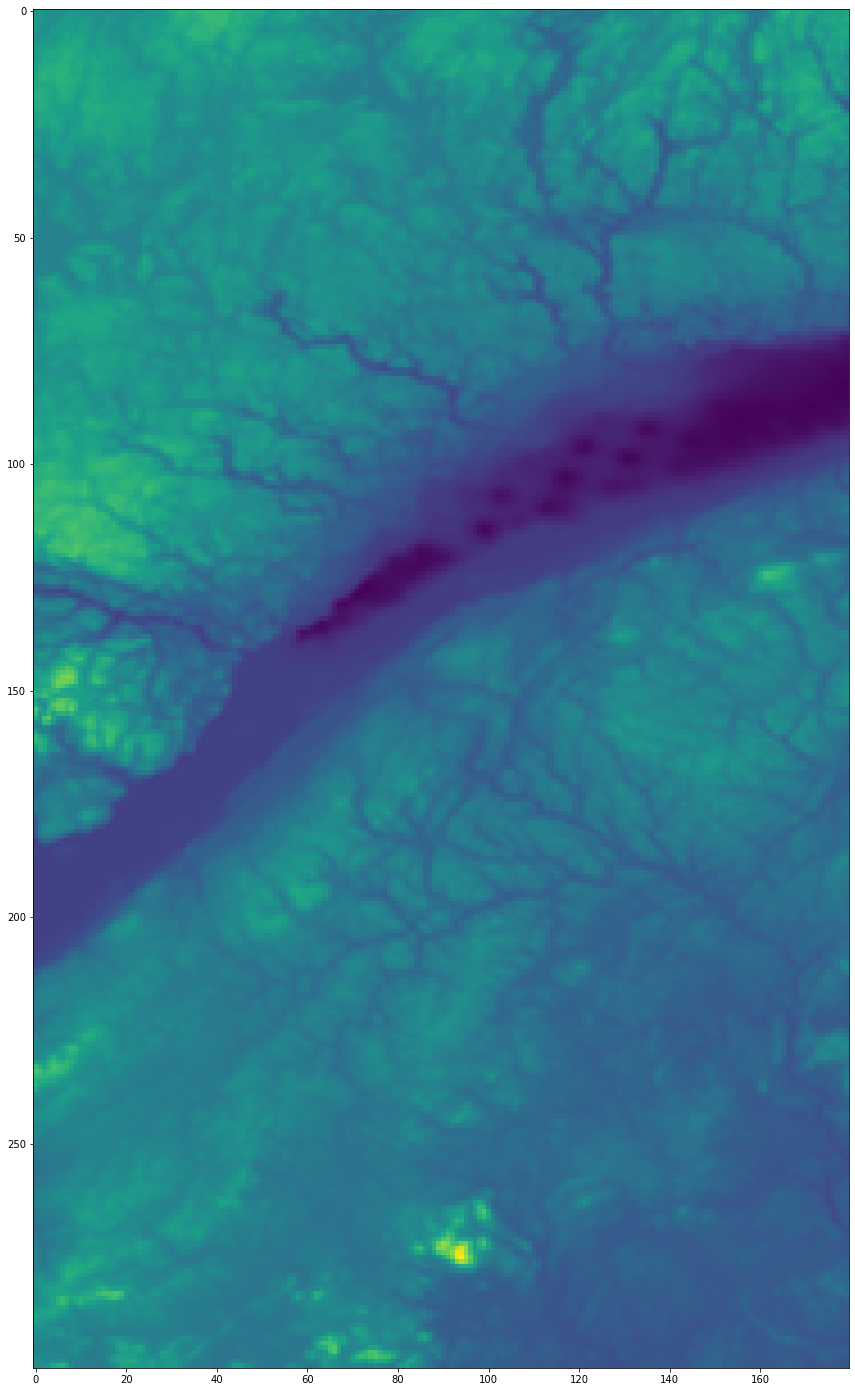

In [19]:
plt.figure(figsize = (25, 25))
plt.imshow(top_s)

In [20]:
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np

In [21]:
s = np.unique(top_s.ravel())
s

array([-311, -301, -296, ..., 1231, 1232, 1281], dtype=int16)

In [22]:
ncolor = s.max()-s.min()
ncolor

1592

In [23]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("", ["red", "green", "yellow"], N=ncolor)

In [24]:
norm = mpl.colors.Normalize(vmin=s.min(), vmax=s.max())
scalarMap2 = cm.ScalarMappable(norm=norm, cmap=cmap)

In [25]:
tops_2 = scalarMap2.to_rgba(top_s, bytes=True)
tops_in = tops_2[:,:,:3]

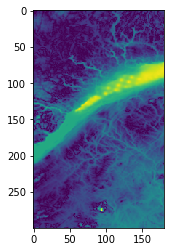

In [26]:
# show one channel
plt.imshow(tops_in[:,:,0])

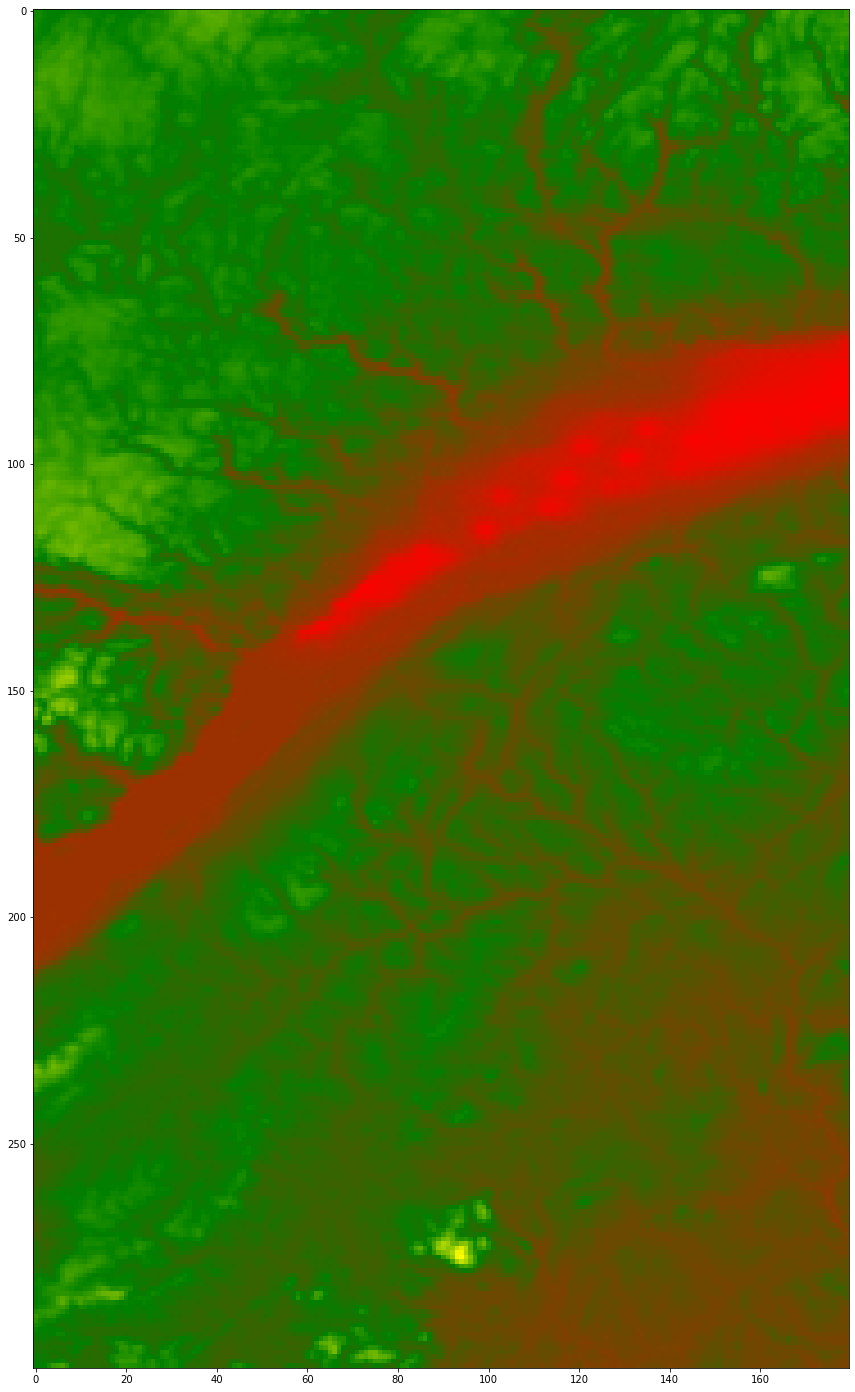

In [27]:
plt.figure(figsize = (25, 25))
plt.imshow(tops_in)

In [28]:
# apply sr model
top_sr = resolve_single(model, tops_in)

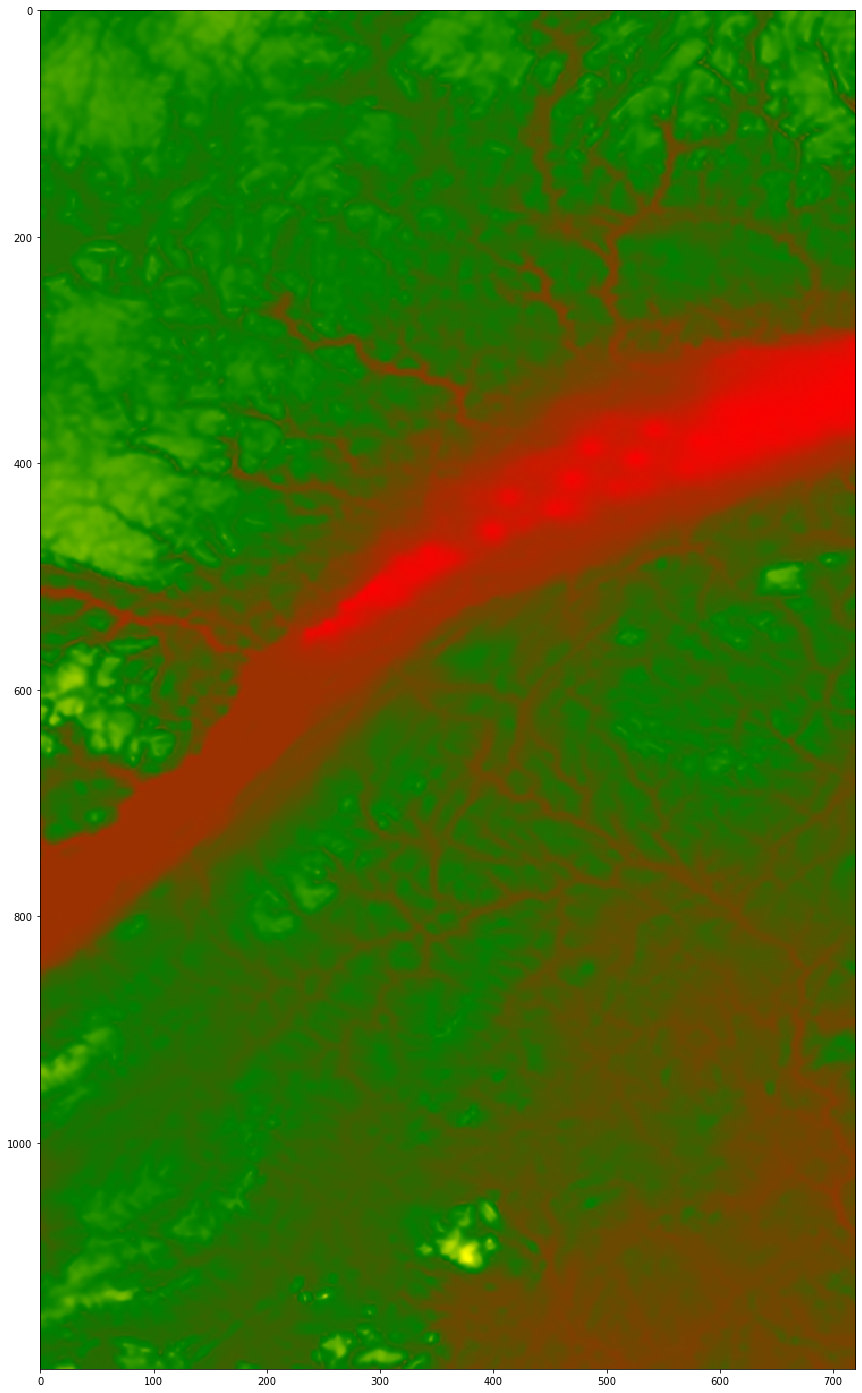

In [29]:
plt.figure(figsize = (25, 25))
plt.imshow(top_sr)

In [30]:
top_sr.shape

TensorShape([1200, 720, 3])

### Convert back from RGB to unique depth value
Tried two ways to match color label and "depth"

In [31]:
import scipy.cluster.vq as scv

In [32]:
arr = top_sr.numpy()
test = arr.reshape((arr.shape[0]*arr.shape[1], arr.shape[2]))

In [33]:
# approach 1: generate new color map 
gradient=cmap(np.linspace(0.0, 1.0, ncolor), bytes=True)
grd = gradient[:,:3]
code, dist = scv.vq(test, grd)
v1 = code.reshape(arr.shape[0], arr.shape[1])
v1.shape

(1200, 720)

In [34]:
v1[:20, :20]  


array([[852, 852, 852, 852, 849, 849, 843, 837, 830, 818, 812, 802, 799,
        799, 796, 796, 796, 796, 796, 796],
       [846, 849, 852, 852, 852, 849, 846, 843, 830, 818, 812, 805, 799,
        796, 796, 796, 796, 796, 796, 796],
       [846, 843, 846, 849, 852, 849, 849, 843, 834, 818, 812, 799, 796,
        796, 796, 796, 796, 796, 796, 793],
       [840, 843, 843, 846, 849, 852, 852, 849, 840, 824, 812, 802, 796,
        796, 796, 796, 796, 796, 796, 796],
       [840, 837, 837, 843, 849, 855, 859, 852, 843, 830, 815, 802, 796,
        796, 796, 796, 796, 796, 796, 793],
       [837, 834, 837, 843, 849, 859, 859, 855, 846, 830, 815, 802, 799,
        799, 796, 796, 796, 796, 793, 793],
       [834, 837, 837, 843, 849, 858, 859, 852, 840, 827, 812, 802, 799,
        790, 799, 796, 793, 793, 796, 793],
       [837, 837, 837, 843, 849, 855, 855, 846, 834, 818, 809, 799, 787,
        790, 790, 790, 790, 793, 793, 793],
       [843, 840, 843, 843, 849, 849, 843, 837, 821, 812, 805, 7

In [35]:
# approach 2: using color map generated previously
g = cmap(s, bytes=True)
grd2 = g[:,:3]
c, d =scv.vq(test, grd2)
v2 = c.reshape(arr.shape[0], arr.shape[1])
v2.shape

(1200, 720)

In [39]:
v2[:20, :20]  

array([[1127, 1127, 1127, 1127, 1126, 1126, 1123, 1121, 1119, 1113, 1107,
        1099, 1096, 1096, 1093, 1093, 1093, 1093, 1093, 1093],
       [1125, 1126, 1127, 1127, 1127, 1126, 1125, 1123, 1119, 1113, 1107,
        1101, 1096, 1093, 1093, 1093, 1093, 1093, 1093, 1093],
       [1125, 1125, 1125, 1126, 1127, 1126, 1126, 1123, 1120, 1113, 1107,
        1096, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1090],
       [1123, 1123, 1123, 1125, 1126, 1127, 1127, 1126, 1123, 1116, 1107,
        1099, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1093],
       [1123, 1121, 1121, 1125, 1126, 1127, 1128, 1127, 1125, 1119, 1110,
        1099, 1093, 1093, 1093, 1093, 1093, 1093, 1093, 1090],
       [1121, 1120, 1121, 1123, 1126, 1128, 1128, 1128, 1125, 1119, 1110,
        1099, 1096, 1096, 1093, 1093, 1093, 1093, 1090, 1090],
       [1120, 1121, 1121, 1123, 1126, 1128, 1128, 1127, 1123, 1117, 1107,
        1099, 1096, 1087, 1096, 1093, 1090, 1090, 1093, 1090],
       [1121, 1121, 1121, 1123, 1126, 112

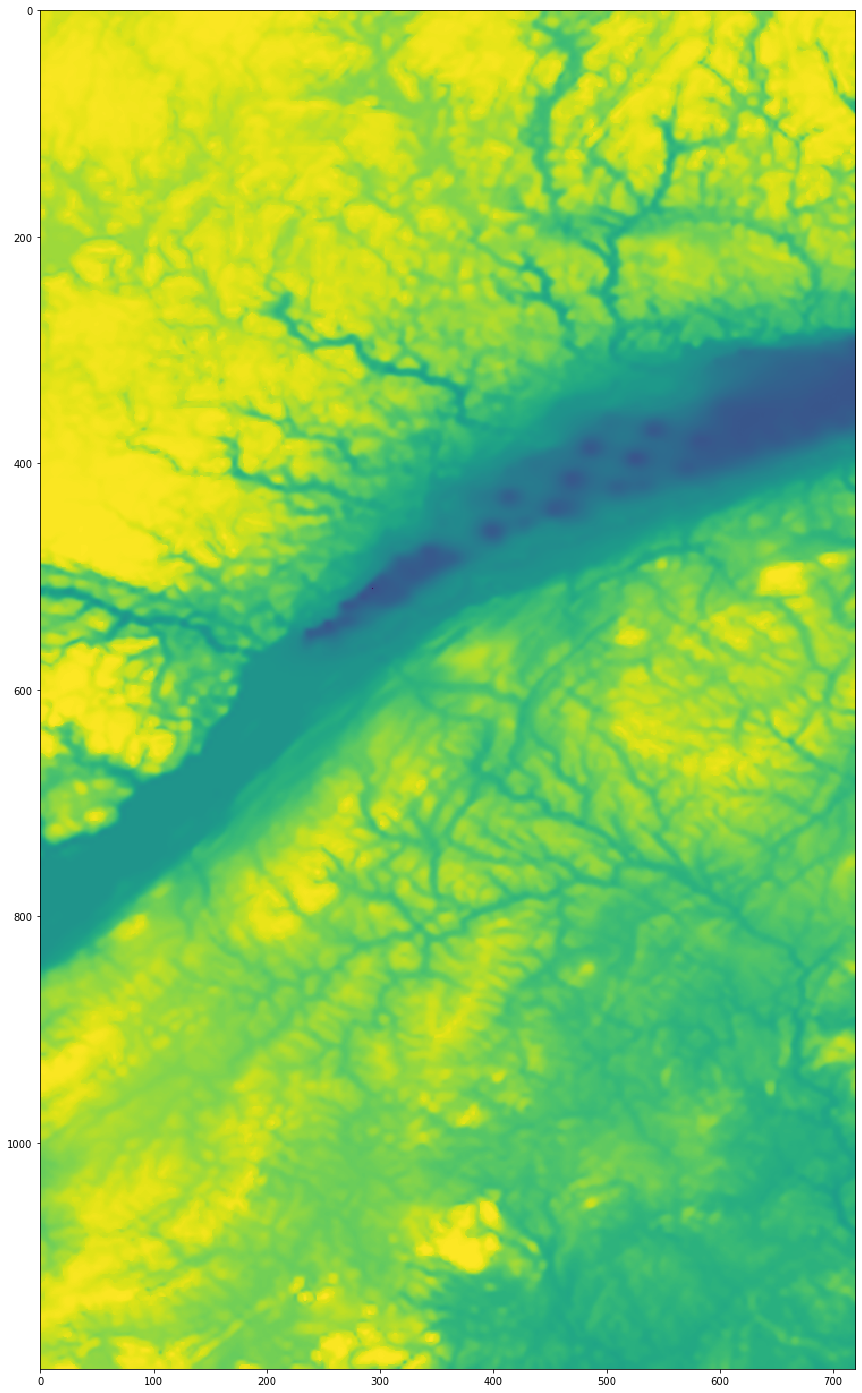

In [40]:
plt.figure(figsize = (25, 25))
plt.imshow(v2)